In [1]:
import os
import numpy as np
import pandas as pd
import csv
from datetime import datetime
from sklearn.metrics import r2_score
import seaborn as sns
import statsmodels.api as sm


from definitions import target_var, country_col, date_col, save_output, fake_num, show_plots, save_figs,fig_size 
from util_general import get_table_path, get_impl_date, get_trans, get_donor_countries
from plot_functions import plot_predictions, plot_diff, plot_cumsum, plot_cumsum_impl, plot_qq
from statistical_tests import shapiro_wilk_test, t_test_result

# custom functions
from definitions import all_paths, country_col, year_col, stat, incl_countries, incl_years, model_val
from util_general import read_data, validate_input, get_trans, get_data_path, get_impl_date
from estimators import arco, sc, did

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

from sklearn.linear_model import Lasso
from definitions import fig_size, show_plots, save_figs, treatment_countries
from util_general import get_impl_date, get_fig_path, get_formal_title, get_model_color, get_formal_country_name

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [2]:
timeframe = 'm'
model = 'lasso'
fig_size = (10, 6)

In [3]:
df = read_data(source_path=get_data_path(timeframe=timeframe), file_name=f'total_{timeframe}')
df_stat = read_data(source_path=get_data_path(timeframe=timeframe), file_name=f'total_{timeframe}_{stat}')

df = df[(df[country_col].isin(incl_countries)) & (df[year_col].isin(incl_years))]
df_stat = df_stat[(df_stat[country_col].isin(incl_countries)) & (df_stat[year_col].isin(incl_years))]

In [4]:
treatment_country = 'portugal'
incl = get_donor_countries() + [treatment_country]
incl

['austria',
 'belgium',
 'bulgaria',
 'croatia',
 'czech_republic',
 'germany',
 'greece',
 'hungary',
 'italy',
 'lithuania',
 'netherlands',
 'romania',
 'slovakia',
 'spain',
 'portugal']

In [5]:
co2 = df[df[country_col].isin(incl)][[date_col, 'country', 'co2']]
co2


co2 = co2.pivot(index='date', columns=[country_col], values='co2')
co2

SS = StandardScaler()
co2_stand = pd.DataFrame(SS.fit_transform(co2), index=co2.index, columns=co2.columns)
co2_stand

co2_stand_pre = co2_stand[co2_stand.index < get_impl_date(treatment_country)]
co2_stand_pre

country,austria,belgium,bulgaria,croatia,czech_republic,germany,greece,hungary,italy,lithuania,netherlands,portugal,romania,slovakia,spain
date,,,,,,,,,,,,,,,
2000-01-01,1.102692,2.004716,0.879690,1.651543,2.021670,1.814757,1.835528,2.036841,1.430227,0.001151,1.386694,2.412063,2.084688,2.394656,1.110720
2000-02-01,0.372235,1.635656,-0.349685,0.718881,1.241028,1.139724,0.987689,0.632242,0.944036,-0.299367,0.843697,1.276648,1.300510,1.388694,-0.096799
2000-03-01,0.128727,1.517510,-0.074713,0.471016,1.158270,0.900358,1.061182,0.660140,0.802985,-0.407740,0.917775,1.209776,0.804791,0.965319,0.200726
2000-04-01,-0.842465,0.554631,-1.081257,-0.732095,-0.077546,-0.175901,0.064940,-0.629442,-0.051141,-1.310192,0.051250,0.949186,-0.367072,-0.554443,-0.062057
2000-05-01,-1.419541,-0.401057,-1.419960,-1.186677,-0.624410,-0.840758,-0.108881,-0.914699,-0.640544,-1.602231,-1.010339,-0.756555,-0.837533,-1.172319,-0.862321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-01,-1.168461,-1.478086,-0.692793,-1.374283,-1.385671,-1.154057,-1.009247,-1.297587,-1.578602,-1.080452,-1.353681,-1.391881,-1.399577,-1.580807,-1.456595
2014-09-01,-0.725139,-1.064875,-0.411691,-1.180031,-1.037997,-0.825571,-1.171447,-1.039547,-1.309915,-0.473755,-1.177319,-1.067957,-1.105997,-1.099163,-1.297772
2014-10-01,0.042826,-0.425648,-0.000499,-0.662932,-0.041281,0.058546,-1.184678,-0.605671,-1.044603,0.715943,-0.574247,-1.030962,-0.148761,-0.167231,-1.248539


In [6]:
total_trend = None

for country in incl:
    co2_country = co2_stand[country]
    res = seasonal_decompose(co2_stand_pre[country], model='additive', period=12)
    if total_trend is None:
        total_trend = pd.DataFrame(res.trend)
        total_trend = total_trend.rename(columns={'trend': country})
    else:
        total_trend[country] = res.trend
    
total_trend.index = pd.to_datetime(total_trend.index)
total_trend

,austria,belgium,bulgaria,croatia,czech_republic,germany,greece,hungary,italy,lithuania,netherlands,romania,slovakia,spain,portugal
date,,,,,,,,,,,,,,,
2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


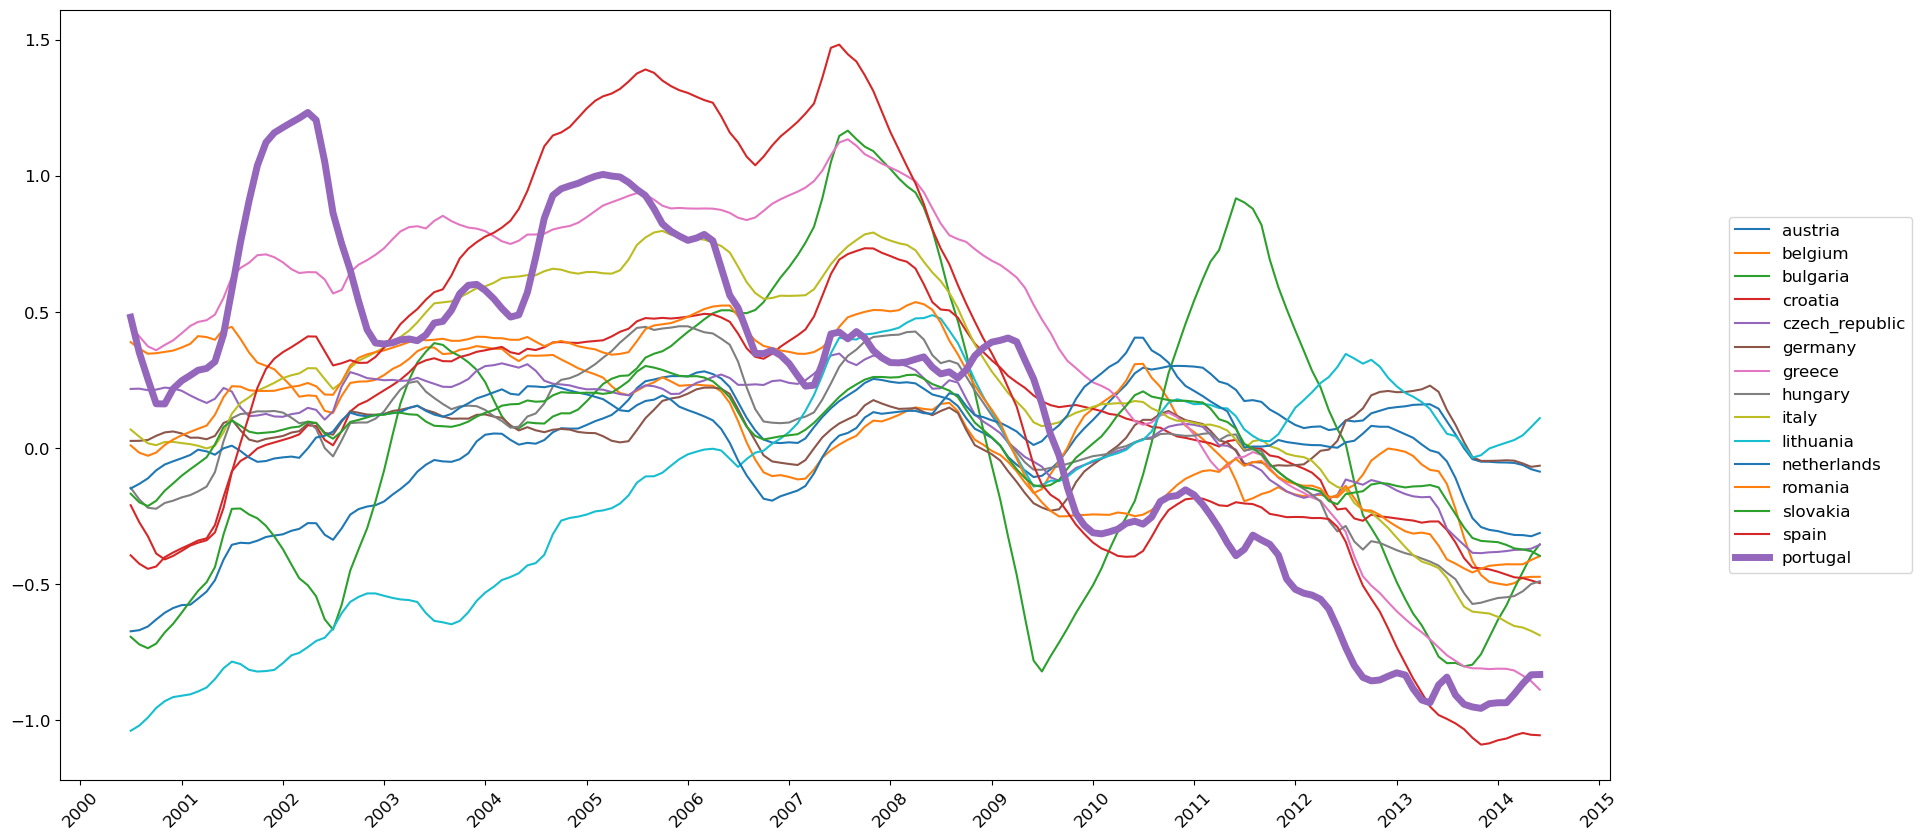

In [7]:
df = total_trend.copy()

fig, ax = plt.subplots(figsize=(20,10))
for country in incl:
    if country==treatment_country:
        ax.plot(df[country], label=country, linewidth=5)
    else:
        ax.plot(df[country], label=country)

ax.xaxis.set_major_locator(mdates.YearLocator())
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.legend(bbox_to_anchor = (1.2, 0.5), loc='center right')

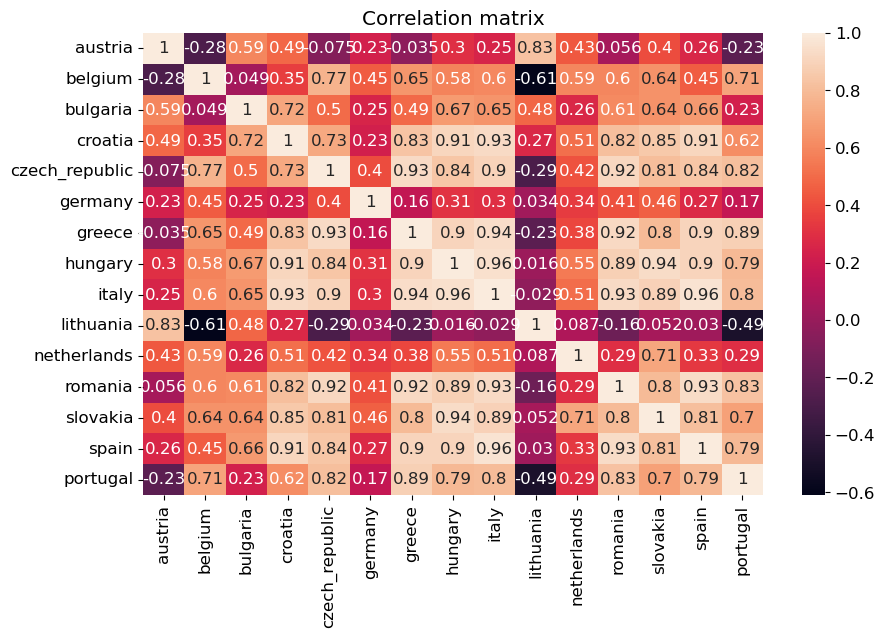

In [8]:
df = total_trend.copy()

matrix = df.corr()
plt.figure(figsize=fig_size)
sns_plot = sns.heatmap(matrix, annot=True)
plt.title('Correlation matrix')

plt.show()

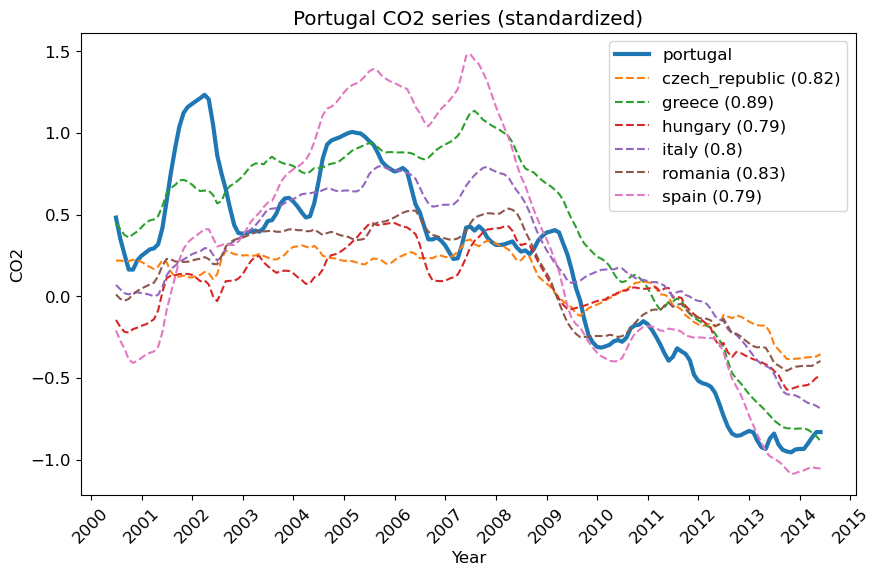

In [9]:
df = total_trend.copy()
incl_countr = [treatment_country] + get_donor_countries(model='did', prox=True, treatment_country=treatment_country)

fig, ax = plt.subplots(figsize=fig_size)
for country in incl_countr:
    corr = round(df[[treatment_country, country]].corr().iloc[1][0], 2)
    if country==treatment_country:
        ax.plot(df[country], label=country, linewidth=3)
    else:
        ax.plot(df[country], label=f'{country} ({round(corr,2)})', linestyle='--')

ax.xaxis.set_major_locator(mdates.YearLocator())
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_title(f'{get_formal_country_name(treatment_country)} CO2 series (standardized)')
ax.set_xlabel('Year')
ax.set_ylabel(f'CO2')
ax.legend(loc='best')
if save_figs:
    plt.savefig(f'corr_{treatment_country}.png', dpi=300, bbox_inches='tight')
if show_plots:
    plt.show()